In [106]:
import re
from collections import Counter
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from spacy.tokenizer import Tokenizer

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import squarify
import spacy
nlp = spacy.load("en_core_web_lg")

In [108]:
from bs4 import BeautifulSoup
import requests

In [142]:
df = pd.read_csv('get_follower_data.csv')

In [143]:
print(df.shape)
df.head()

(16322, 6)


,Unnamed: 0,hours,mins,min_bin,text,time
0,0,14,58,30,@DeafHustle @DanaMattioli We use Accusales to ...,14:30
1,1,7,7,0,No house\nNo car\nNo boat\nNo golf\nNo fiat mo...,07:00
2,2,4,52,30,Travis Scott &amp; Kid Cudi are working on a j...,04:30
3,3,1,34,30,Iftar is served🤗.. #RamadanMubarak🙏🏾 https://t...,01:30
4,4,14,26,0,Look at bitcoin go 🚀 https://t.co/hsAVMIu7hl,14:00


In [144]:
df['text'] = df['text'].apply(lambda x: x[2:-1].replace('\\n', ' ').replace('\n\n', ' ').replace('\n', ' '))
# df['text'] = [BeautifulSoup(text).get_text() for text in df['text'] ]
df.head()

,Unnamed: 0,hours,mins,min_bin,text,time
0,0,14,58,30,eafHustle @DanaMattioli We use Accusales to es...,14:30
1,1,7,7,0,house No car No boat No golf No fiat money Ne...,07:00
2,2,4,52,30,avis Scott &amp; Kid Cudi are working on a joi...,04:30
3,3,1,34,30,tar is served🤗.. #RamadanMubarak🙏🏾 https://t.c...,01:30
4,4,14,26,0,ok at bitcoin go 🚀 https://t.co/hsAVMIu7h,14:00


In [145]:
tokenizer = Tokenizer(nlp.vocab)

In [146]:
STOP_WORDS = nlp.Defaults.stop_words.union([' '])

In [147]:
spanish_stop_words = ['de', 'e', 'la', 'le', 'que', 'y', 'el', 'un', 'r', 'en', 'w', "it's", "it’s", 'u', "i'm"]

In [148]:
spanish_stop_words

['de',
 'e',
 'la',
 'le',
 'que',
 'y',
 'el',
 'un',
 'r',
 'en',
 'w',
 "it's",
 'it’s',
 'u',
 "i'm"]

In [149]:
tokens = []

"""create tokens without stop,, punct, pronouns or extended stop words"""
for doc in tokenizer.pipe(df['text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if ((token.is_stop == False) and (token.is_punct == False) and (token.pos_!= 'PRON') and token.text.lower() not in STOP_WORDS and token.text.lower() not in spanish_stop_words):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens

In [150]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [151]:
wc = count(df['tokens'])
wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1134,people,495,515,1.0,0.003290,0.003290,0.030327
77,like,469,485,2.0,0.003099,0.006389,0.028734
25,&amp;,410,440,3.0,0.002811,0.009200,0.025119
17,new,362,379,4.0,0.002421,0.011621,0.022179
245,time,355,372,5.0,0.002377,0.013998,0.021750
627,day,309,329,6.0,0.002102,0.016100,0.018932
43,know,301,313,7.0,0.002000,0.018099,0.018441
374,good,258,267,8.0,0.001706,0.019805,0.015807
218,want,245,259,9.0,0.001655,0.021460,0.015010
115,need,244,251,10.0,0.001604,0.023063,0.014949


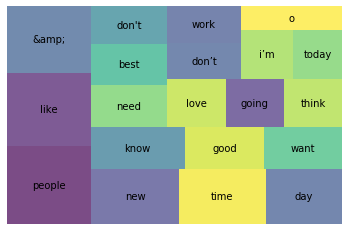

In [152]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.7 )
plt.axis('off')
plt.show()

## Word count per tweet

In [153]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [154]:
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97,
                        min_df=3,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(df['text']) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,,,$,-PRON-,1,100daysofcode,2,2014,2018,2020,...,🦋,🦠,🧐,🧠,🧡,🧢,🧢 https://t.co/8qi9mfljd,🧢 🧢,🧶,🧶 https://t.co/rahrmjbcu
0,0.127498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.103653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


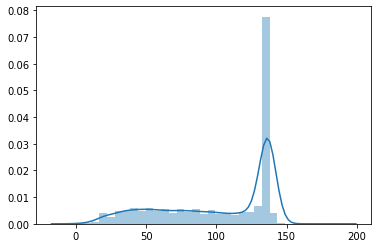

In [155]:
doc_len = [len(doc) for doc in df['text']]

sns.distplot(doc_len); # Visualizing the lenth of characters.

## Sentiment Analysis


In [158]:
from sklearn.model_selection import train_test_split

In [159]:
df = pd.read_csv('get_follower_data.csv')

In [160]:
train, test = train_test_split(df.text, train_size = 0.5)
train.shape, test.shape 

/Applications/anaconda3/envs/U4-S1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((8161,), (8161,))

In [161]:
import re

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(train)
reviews_test_clean = preprocess_reviews(test)

In [163]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

target = [1 if i < 4080 else 0 for i in range(8161)]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

/Applications/anaconda3/envs/U4-S1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Applications/anaconda3/envs/U4-S1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.5222929936305732
Accuracy for C=0.05: 0.5222929936305732
Accuracy for C=0.25: 0.5110240078392945
Accuracy for C=0.5: 0.5031847133757962
Accuracy for C=1: 0.5007349338559529


In [165]:
final_model = LogisticRegression(C=0.05)
final_model.fit(X, target)
final_model = LogisticRegression(C=0.05)
final_model.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_model.predict(X_test)))

Final Accuracy: 0.5030020830780542


In [166]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
print('Positive')
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

print('Negative')
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

Positive
('come', 0.37739485673234374)
('blog', 0.30891906869965635)
('still', 0.3001942623358227)
('ll', 0.2990590020961237)
('way', 0.27535262285660206)
Negative
('days', -0.4742626357977561)
('believe', -0.3519561329005742)
('times', -0.29235112701129595)
('didnt', -0.2594849867415561)
('companies', -0.24770755300989453)
